
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [17]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [219]:
# In the three cells immediately following, describe **WHAT** you are planning to analyze for 
# your final project (i.e., texts, contexts and the social game, world and actors you intend 
# to learn about through your analysis) (<200 words), **WHY** you are going to do it 
# (i.e., why would theory and/or the average person benefit from knowing the results of 
# your investigation) (<200 words), 
# and HOW you plan to investigate it (i.e., what are the approaches and operations 
# you plan to perform, in sequence, to yield this insight) (<400 words).

# What?
## I am interested in analyzing two primary collections, those of movies and soap operas. 
# I will follow the actors in across these texts, their associated networks, 
# and primary dialogues as a way to provide insight into the culture around 
# violence, care, and collaboration constructed in these media. I am interested in 
# learning how these themes vary across different genre types, such as drama versus thriller, 
# which extends to soap operas as all of these forms typically represent 
# intimate groups of people (often pitted against each other) who are experiencing 
# difficult situations. Their relationships and dialogues offer the opportunity to 
# understand how violence and care are conceptualized and portrayed in relation to 
# different themes and relationships.

## Why?
## Thousands upon thousands of viewers partake in watching movies and soap operas, 
# and these forms serve as one of the largest sources of popular media in society. 
# With this level of importance and accessibility across so many people, it is 
# essential to understand how these media approach themes of violence and care, 
# as they reflect what is being provided to and taken up by popular audiences. 
# For instance, if all movies and soap operas benefit from extremely violent language 
# and images, this may indicate that the 'real-life' social world is more conducive 
# and more greatly values violence over care. This may further give insight into themes of 
# collaboration versus competition, as a more violent social world may be interrelated
# with a more competitive one as well. This offers the opportunity to assess different 
# values among viewing audiences for these media.

## How?
## For this assignment, I aim to analyze the Movie and SOAP corpora for patterns in 
# the text data. I will use clustering/partitioning to assess emergent clusters in 
# the movie corpus, using both k-means (a flat clustering method) and Ward's 
# (minimum variance) method (a hierarchical method).  I will use the sillhouette 
# method to demonstrate a simple (graphical) approach to identifying optimal cluster 
# number and evaluate the quality of unsupervised clusters on labeled data.
## I will also explore topic modeling on the Movie corpus, which is a method of 
# two dimensional content clustering (e.g., words cluster in topics; topics cluster 
# in documents). As noted above, topic modeling models and computationally induces 
# topics from data, which are sparse distributions over (nonexclusive clusters of) 
# words, from which documents can formally be described as sparse mixtures. I will 
# assess these topics for patterns related to the themes discussed above across 
# select movies. 
## Expanded methods will be explored over the course of this class, with each week 
# offering different insights into how these broadly view forms of media make 
# sense of violence and care.

## Pitch Your Sample

# In the cell immediately following, describe the rationale behind your proposed sample design 
# for your final project. What is the social game, social work, or social actors you about 
# whom you are seeking to make inferences? What are its virtues with respect to your 
# research questions? What are its limitations? What are alternatives? 
# What would be a reasonable path to "scale up" your sample for further analysis 
# (i.e., high-profile publication) beyond this class? (<300 words).

## Which (words)?
# I am interested in looking at both the Movie and Soap Opera corpora for this course. 
# As discussed above, these popularly viewed media offer social worlds that have been 
# consistently taken up by popular audiences. As these forms are so widely viewed and 
# popular, it is of interest to analyze them for various themes that reflect social 
# values on violence, competition, and collaboration. Limitations exist in the fact 
# that these selections do not provide as relevant insights as perhaps the most popular
# movies of all time, but do provide a proxy in this case. Alternatives would include 
# the most popular movies, or popularity as associated with different viewer demogrpahics 
# (i.e. viewership location, age, race, gender, etc.). A “scaled up” version would include
# one that offers a more nuanced sample in relation to different audience groups and 
# greater contextualization into that sample’s social and political location in time.

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom"
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('byk', 0.08265545268171724),
 ('170', 0.05464092321093494),
 ('mlm', 0.19706119834212132),
 ('brussels', 0.05749878121929968),
 ('pho', 0.07820822067701588),
 ('sucked', 0.0749569030656185),
 ('12mph', 0.10567912764152107),
 ('fishfinder', 0.1109950967372947),
 ('abstraction', 0.05330795380898169),
 ('tiresome', 0.21470375597395805),
 ('define', 0.09901319943986409),
 ('cutout', 0.19389877721110985),
 ('mcloughlin', 0.1817286448065436),
 ('digitizer', 0.19389877721110985),
 ('fact', 0.33279218254193177),
 ('jabido', 0.18819404816424326),
 ('bubba', 0.08243502153417578),
 ('harm', 0.1619412292430009),
 ('compudyne', 0.13074268623716792),
 ('anyopne', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [13]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['define', 'fact', 'centris', 'list', 'white', 'hp', 'sent', '33', 'value', 'asking'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [16]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [17]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [18]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,category,source_file,text,kmeans_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",0
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,0
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,0
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",0
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,0
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,0
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,0
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",0
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,0
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,0


We can also look at the distinguishing features in each cluster:

In [19]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 mac
 just
 know
 drive
 apple
 does
 like
 don
 thanks
 problem


Cluster 1:
 car
 cars
 engine
 like
 just
 good
 think
 new
 don
 dealer


Cluster 2:
 window
 server
 use
 motif
 program
 thanks
 application
 widget
 using
 windows


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 sell
 interested
 email




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [20]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [21]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [22]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('rec.autos', 'blue'), ('misc.forsale', 'green'), ('comp.windows.x', 'orange'), ('comp.sys.mac.hardware', 'red')])


Let's plot the data using the true labels as the colors of our data points.

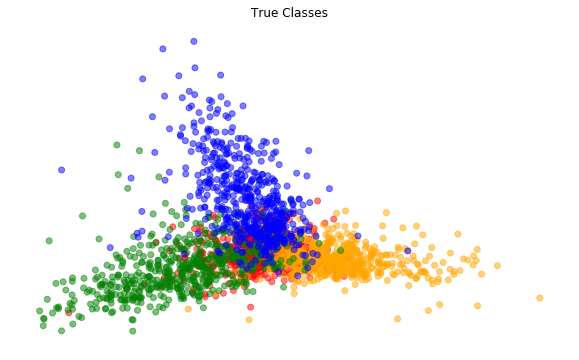

In [23]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

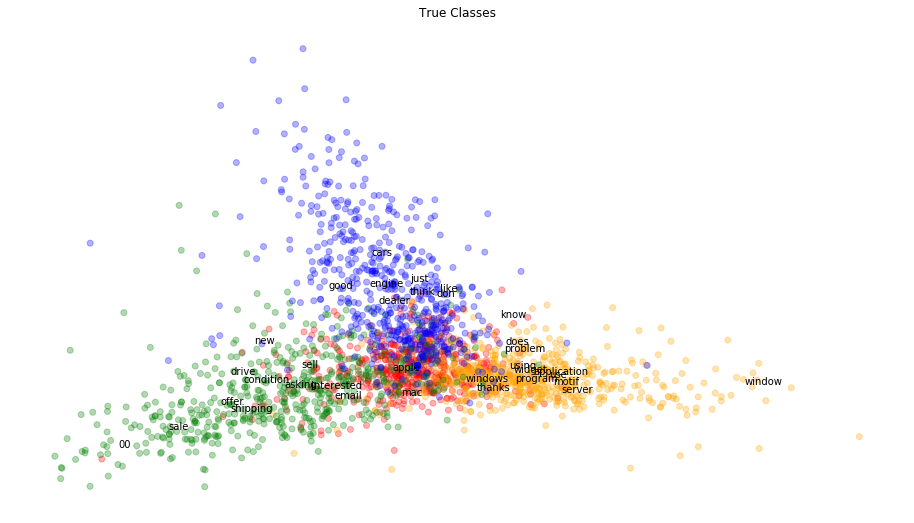

In [24]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [25]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

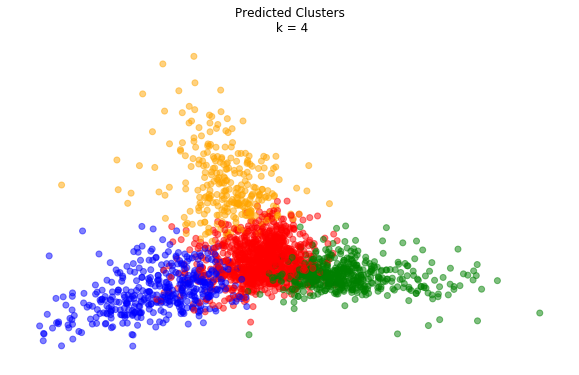

In [26]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [27]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [28]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


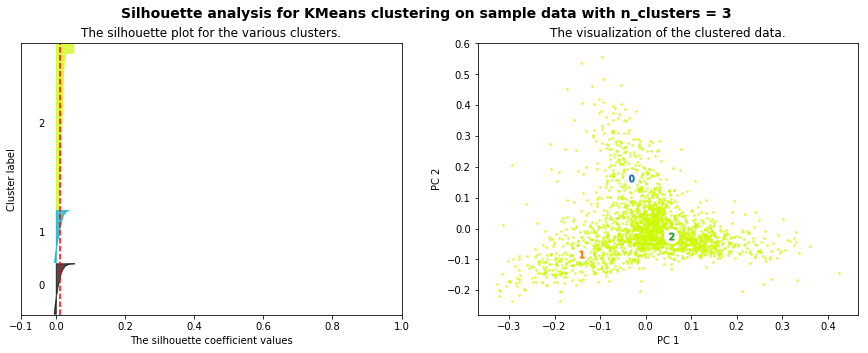

For n_clusters = 3, The average silhouette_score is : 0.013


In [29]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


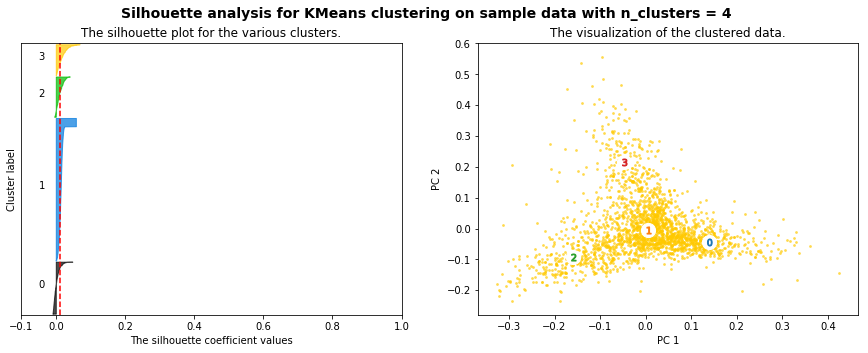

For n_clusters = 4, The average silhouette_score is : 0.012


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


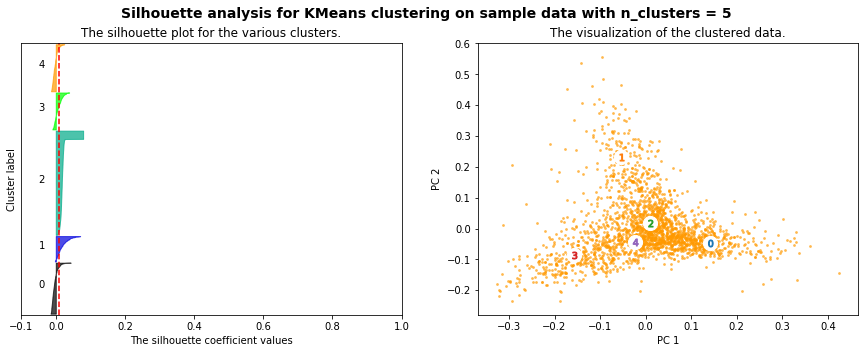

For n_clusters = 5, The average silhouette_score is : 0.010


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


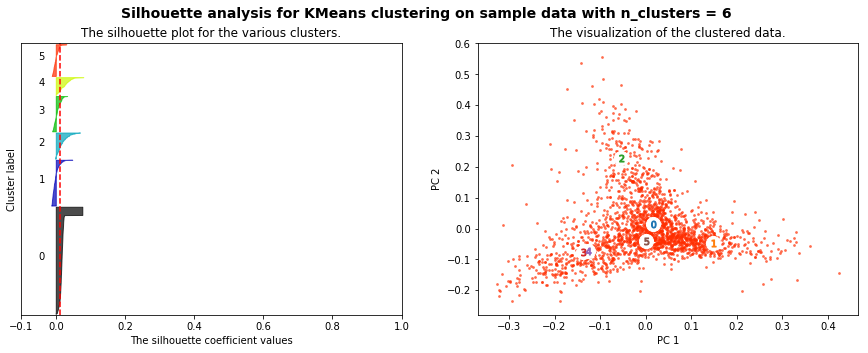

For n_clusters = 6, The average silhouette_score is : 0.011


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [33]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [34]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [35]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [36]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [37]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [38]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And visualize:

In [39]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

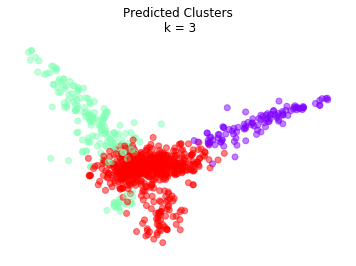

In [40]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [41]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,2
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,1
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [32]:
# read in corpora data
import pandas as pd 
movie_df = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/movie_df.csv")
movie_df.head()

,Unnamed: 0,Movie Name,Genre,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count
0,6850720,Animal Crackers,"Comedy, Musical",1930,English,@@6850720 You must do your best tonight Be on ...,"['You', 'must', 'do', 'your', 'best', 'tonight...","['good', 'tonight', 'toe', 'man', 'guest', 'to...",4868
1,176501,Anna Christie,"Drama, Romance",1930,English,@@176501 Either you're flat or I am . I beg yo...,"['Either', 'you', ""'re"", 'flat', 'or', 'I', 'a...","['flat', 'beg', 'pardon', 'excuse', 'lady', 'f...",3825
2,4056770,Ladies of Leisure,"Drama, Romance",1930,English,@@4056770 Look out ! There's another bottle co...,"['Look', 'out', 'There', ""'s"", 'another', 'bot...","['look', 'bottle', 'come', 'look', 'look', 'co...",3195
3,5992934,Over the Hill,Drama,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","['Good', 'morning', 'kitty', 'Come', 'in', 'he...","['good', 'morning', 'kitty', 'come', 'baby', '...",2651
4,4436137,Design for Living,"Comedy, Romance",1933,"English, French",@@4436137 [Train_engine_grinding] **26;1426;TO...,"['Train_engine_grinding', '26;1426;TOOLONG', '...","['train_engine_grinde', '26;1426;toolong', 'wh...",3417


In [33]:
# duplicate genre column named 'type'
movie_df['Type'] = movie_df['Genre']

In [57]:
# reduce to only single genre movies of interest
movie_singleGenre = movie_df.set_index(['Genre'])
movie_df_subset = movie_singleGenre.loc[movie_singleGenre.index.isin(['Drama','Horror','Crime','Comedy','Action','Thriller'])]
movie_df_subset.head()

,Unnamed: 0,Movie Name,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,Type
Genre,,,,,,,,,
Drama,5992934,Over the Hill,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","['Good', 'morning', 'kitty', 'Come', 'in', 'he...","['good', 'morning', 'kitty', 'come', 'baby', '...",2651,Drama
Comedy,3904983,A Chump at Oxford,1940,English,"@@3904983 Well , what's the matter now ? - I j...","['Well', 'what', ""'s"", 'the', 'matter', 'now',...","['matter', 'see', 'hand', 'siddown', 'crazy', ...",1056,Comedy
Comedy,6017201,The Happiest Days of Your Life,1950,English,"@@6017201 BIG BEN CHIMES Excuse me , could you...","['BIG', 'BEN', 'CHIMES', 'Excuse', 'me', 'coul...","['big', 'ben', 'chime', 'excuse', 'tell', 'way...",4247,Comedy
Drama,6860500,The Company She Keeps,1951,English,@@6860500 If no-one has any objections . I was...,"['If', 'no', 'one', 'has', 'any', 'objections'...","['objection', 'wonder', 'mildred', 'lynch', 'p...",3067,Drama
Drama,4788308,My Son John,1952,English,"@@4788308 What's the matter , pop ? You're get...","['What', ""'s"", 'the', 'matter', 'pop', 'You', ...","['matter', 'pop', 'gettin', 'kinda', 'clumsy',...",4916,Drama


In [58]:
len(movie_df_subset)

96

In [59]:
# convert the documents into word count vectors
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
movieVects = ngCountVectorizer.fit_transform(movie_df_subset['Text'])
print(movieVects.shape)

(96, 23656)


In [60]:
# This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, 
# a data structure that contains and indexes only the nonzero entries.
movieVects

<96x23656 sparse matrix of type '<class 'numpy.int64'>'
	with 127527 stored elements in Compressed Sparse Row format>

In [61]:
# We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices)
movieVects[:10,:20].toarray()

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  8,  0,  0,
         0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,
         0,  0,  0,  0],
       [ 1, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])

In [220]:
# We can also lookup the indices of different words using the Vectorizer
ngCountVectorizer.vocabulary_.get('kill')

11701

In [221]:
# We can also lookup the indices of different words using the Vectorizer
ngCountVectorizer.vocabulary_.get('save')

18156

In [63]:
# start with term frequency–inverse document frequency(tf-idf), a method for weighting document-distinguishing words
#initialize
movieTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(movieVects)
#train
movieTF = movieTFTransformer.transform(movieVects)
print(movieTF.shape)

(96, 23656)


In [64]:
# This gives us the tf-idf for each word in each text
list(zip(ngCountVectorizer.vocabulary_.keys(), movieTF.data))[:20]

[('5992934', 0.007216911763614937),
 ('good', 0.045561194126243015),
 ('morning', 0.005408984234219159),
 ('kitty', 0.42567172797947045),
 ('come', 0.007999310800125744),
 ('in', 0.004561294114699941),
 ('here', 0.028935239191922466),
 ('baby', 0.0014584316348279715),
 ('isaac', 0.010323575767242594),
 ('tommy', 0.005539467821333463),
 ('johnny', 0.010982645451709032),
 ('susan', 0.01578285774104862),
 ('daddy', 0.002190700256646273),
 ('no', 0.0032386918093435654),
 ('pa', 0.0023913656580263312),
 ('children', 0.010643019600966528),
 ('time', 0.0041770999130336965),
 ('to', 0.0019270646191474907),
 ('get', 0.009594480386506257),
 ('up', 0.0018228691522130874)]

In [65]:
# To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents.
#initialize
movieTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
movieTFVects = movieTFVectorizer.fit_transform(movie_df_subset['Text'])

In [66]:
movie_df_subset['Text']

Genre
Drama     @@5992934 Good morning , kitty ! Come in here ...
Comedy    @@3904983 Well , what's the matter now ? - I j...
Comedy    @@6017201 BIG BEN CHIMES Excuse me , could you...
Drama     @@6860500 If no-one has any objections . I was...
Drama     @@4788308 What's the matter , pop ? You're get...
                                ...                        
Drama     @@6790333 ? I can feel ? ? your presence echoi...
Comedy    @@6898981 ? [light_music] Oh . Hi , [Mary] . Y...
Horror    @@6908275 - Do you remember what I told you th...
Comedy    @@7066738 - You are not just a mom . You are a...
Drama     @@7039258 Dr . Branson , please call 5914 . Dr...
Name: Text, Length: 96, dtype: object

In [67]:
# look at the words
try:
    print(movieTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(movieTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['kitty', 'tommy', 'johnny', 'susan', 'daddy', 'pa', 'children', 'wake', 'alright', 'ma'] ...


In [68]:
# k-means clustering: true number of clusters is 5
numClusters = len(set(movie_df_subset['Type']))
numClusters

5

In [69]:
#  initialize our cluster finder
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [70]:
# calculate the clusters
km.fit(movieTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [71]:
# evaluate cluster metrics ( Homogeneity, Completeness, V-measure and Adjusted Rand Score)
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(movie_df_subset['Type'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(movie_df_subset['Type'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(movie_df_subset['Type'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(movie_df_subset['Type'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'base', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'multilabel_confusion_matrix', 'mutual_info_score', 'normalized_mutual_info_score'

In [ ]:
# note that these measures are fairly low

In [72]:
movie_df_subset['kmeans_predictions'] = km.labels_
movie_df_subset

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,Movie Name,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,Type,kmeans_predictions
Genre,,,,,,,,,,
Drama,5992934,Over the Hill,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","['Good', 'morning', 'kitty', 'Come', 'in', 'he...","['good', 'morning', 'kitty', 'come', 'baby', '...",2651,Drama,2
Comedy,3904983,A Chump at Oxford,1940,English,"@@3904983 Well , what's the matter now ? - I j...","['Well', 'what', ""'s"", 'the', 'matter', 'now',...","['matter', 'see', 'hand', 'siddown', 'crazy', ...",1056,Comedy,4
Comedy,6017201,The Happiest Days of Your Life,1950,English,"@@6017201 BIG BEN CHIMES Excuse me , could you...","['BIG', 'BEN', 'CHIMES', 'Excuse', 'me', 'coul...","['big', 'ben', 'chime', 'excuse', 'tell', 'way...",4247,Comedy,0
Drama,6860500,The Company She Keeps,1951,English,@@6860500 If no-one has any objections . I was...,"['If', 'no', 'one', 'has', 'any', 'objections'...","['objection', 'wonder', 'mildred', 'lynch', 'p...",3067,Drama,2
Drama,4788308,My Son John,1952,English,"@@4788308 What's the matter , pop ? You're get...","['What', ""'s"", 'the', 'matter', 'pop', 'You', ...","['matter', 'pop', 'gettin', 'kinda', 'clumsy',...",4916,Drama,2
...,...,...,...,...,...,...,...,...,...,...
Drama,6790333,Mothers and Daughters,2016,English,@@6790333 ? I can feel ? ? your presence echoi...,"['I', 'can', 'feel', 'your', 'presence', 'echo...","['feel', 'presence', 'echo', 'field', 'life', ...",3550,Drama,3
Comedy,6898981,My Dead Boyfriend,2016,English,"@@6898981 ? [light_music] Oh . Hi , [Mary] . Y...","['light_music', 'Oh', 'Hi', 'Mary', 'You', 'ok...","['light_music', 'oh', 'hi', 'mary', 'okay', 'r...",4358,Comedy,3
Horror,6908275,Ghosts of Darkness,2017,English,@@6908275 - Do you remember what I told you th...,"['Do', 'you', 'remember', 'what', 'I', 'told',...","['remember', 'tell', 'night', 'close', 'eye', ...",1833,Horror,0


In [74]:
# look at the distinguishing features in each cluster:
terms = movieTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 jack
 helen
 bob
 ron
 harry
 papa
 ray
 ben
 pond
 dr


Cluster 1:
 henry
 laughs
 george
 brother
 madison
 church
 truth
 catherine
 mary
 walter


Cluster 2:
 ok
 ain
 mama
 alright
 ma
 john
 daddy
 larry
 kitty
 pa


Cluster 3:
 fuck
 fucking
 yo
 um
 joe
 val
 ok
 nigga
 luke
 mike


Cluster 4:
 dave
 smith
 larry
 joy
 er
 jolly
 jonny
 andrew
 reggie
 joan




In [75]:
# construct a visualization of the clusters. First, we will first reduce the dimensionality of the data using principal components analysis (PCA).
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(movieTFVects.toarray())
reduced_data = pca.transform(movieTFVects.toarray())

In [76]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [79]:
# build a color map for the true labels
colordict = {
    'Drama':'red',
    'Horror':'orange',
    'Crime':'yellow',
    'Comedy':'green',
    'Action':'blue',
    'Thriller':'purple',
    }
colors = [colordict[c] for c in movie_df_subset['Type']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('Drama', 'red'), ('Horror', 'orange'), ('Crime', 'yellow'), ('Comedy', 'green'), ('Action', 'blue'), ('Thriller', 'purple')])


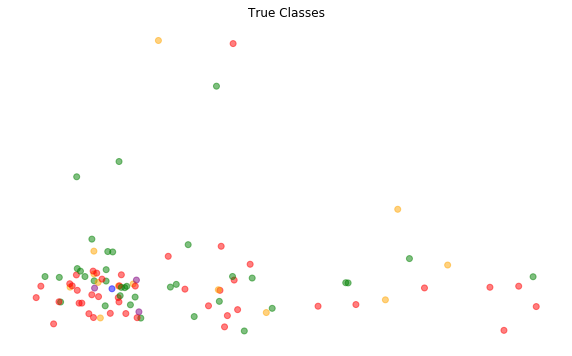

In [80]:
# plot the data using the true labels as the colors of our data points.
# note that the output is quite messy and over-lapping
# this is possibly due to small sample size
# it could also represent an actual overlapping of these genres and a human subjectivity in classifying
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

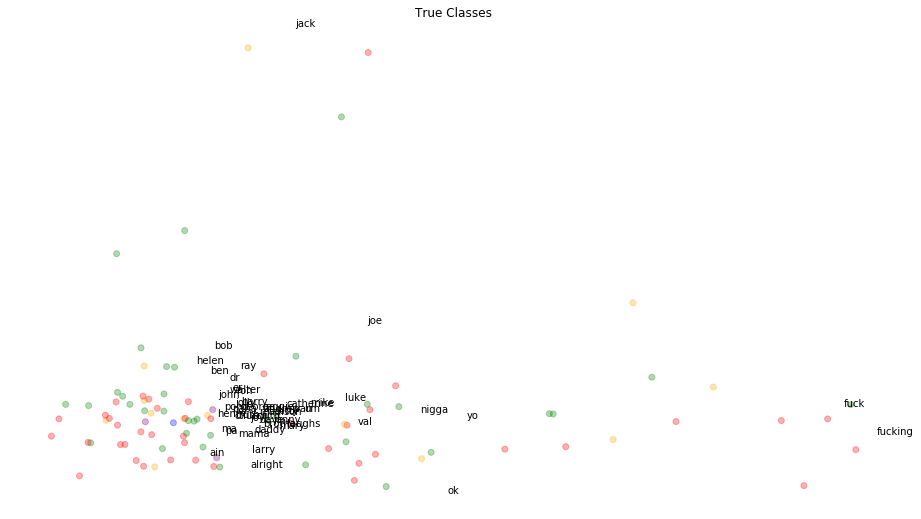

In [81]:
# do a biplot and map our feature vectors to the same space.
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [82]:
# do it again with predicted clusters.
# result in a somewhat cleaner clustering separation (though still messy/overlapping)
# perhaps this is due to the small sample suze
moviesCategories = ['Drama','Horror','Crime','Comedy','Action','Thriller']
colors_p = [colordict[moviesCategories[l]] for l in km.labels_]

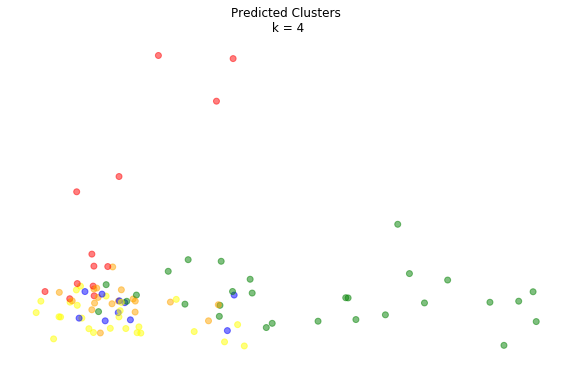

In [83]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

In [84]:
# three clusters
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(movieTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [85]:
# Silhouette method: identifying the "best" number of clusters in an unsupervised way
# here define helper function
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


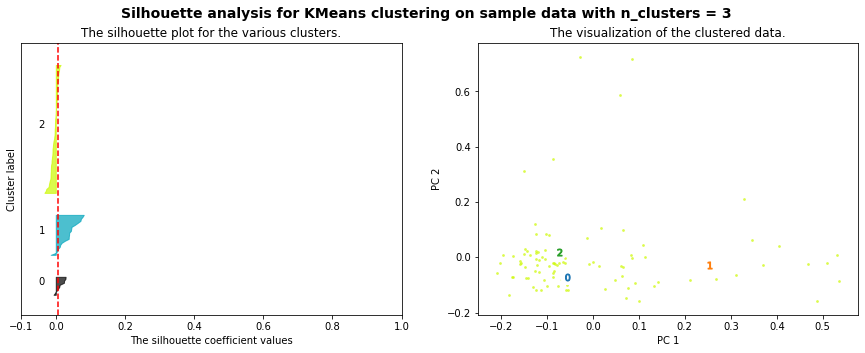

For n_clusters = 3, The average silhouette_score is : 0.006


In [86]:
# examine a few different numbers of clusters:
X = movieTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


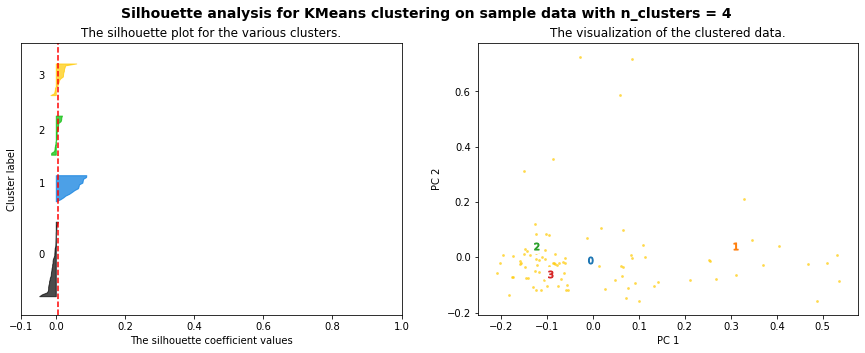

For n_clusters = 4, The average silhouette_score is : 0.007


In [87]:
X = movieTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


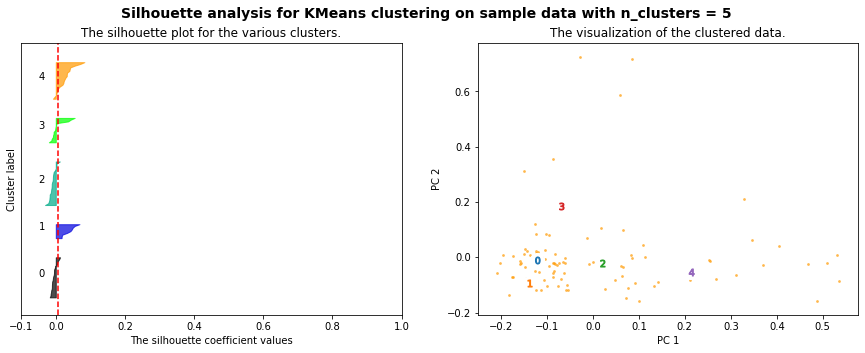

For n_clusters = 5, The average silhouette_score is : 0.006


In [88]:
X = movieTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


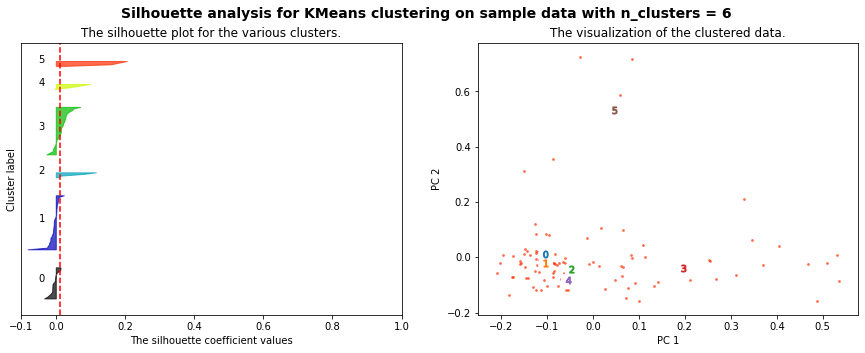

For n_clusters = 6, The average silhouette_score is : 0.011


In [89]:
X = movieTFVects.toarray()
plotSilhouette(6, X)

In [ ]:
# best read is n_clusters=6, which reflects the 6 genre types selected

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [42]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [43]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [44]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [45]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [46]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [47]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 43.        ,  45.        ,   0.        ,   2.        ],
       [ 48.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [105.        , 202.        ,   0.37033177,   5.        ],
       [ 19.        , 154.        ,   0.40914841,   2.        ],
       [110.        , 144.        ,   0.44134524,   2.        ],
       [ 12.        , 149.        ,   0.45096656,   2.        ],
       [  1.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [102.        , 146.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

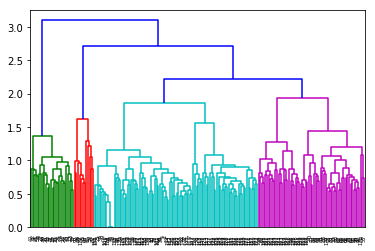

In [48]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

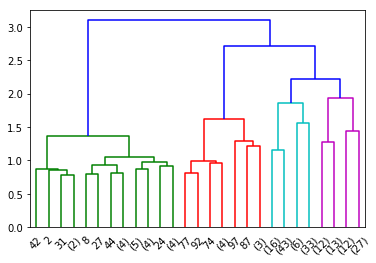

In [49]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [50]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3,
       1, 3, 3, 1, 3, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2,
       3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [51]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [52]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,category,source_file,text,kmeans_predictions,wald_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",0,4
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,0,4
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,0,4
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",0,4
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,0,4
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,0,4
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,0,4
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",0,4
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,0,3
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [53]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

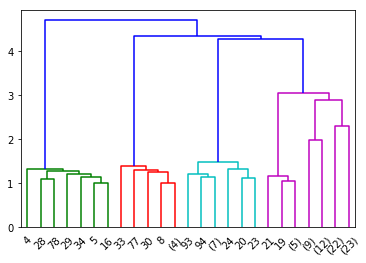

In [54]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [55]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [97]:
# Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).
movieTFVects

<96x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 25365 stored elements in Compressed Sparse Row format>

In [98]:
movieTFVects[:50].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.01557721,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.00903125, ..., 0.        , 0.        ,
         0.01734736],
        ...,
        [0.10669233, 0.013116  , 0.01027978, ..., 0.        , 0.03708212,
         0.        ],
        [0.02293165, 0.        , 0.        , ..., 0.03163672, 0.05313435,
         0.        ],
        [0.03140908, 0.        , 0.01513128, ..., 0.04333228, 0.        ,
         0.        ]])

In [99]:
movieCoocMat = movieTFVects * movieTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
movieCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

In [113]:
# note that code requires numeric indexing
movie_df_subset.index = range(len(movie_df_subset))

In [115]:
# compute a tree of nested clusters
selectIndices = []
indexToCat = []
for c in set(movie_df_subset['Type']):
    selectIndices += list(movie_df_subset[movie_df_subset['Type'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [117]:
subCoocMat = movieCoocMat[selectIndices,:][:,selectIndices]

In [118]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 64.        ,  71.        ,   0.21603902,   2.        ],
       [ 53.        ,  75.        ,   0.22601752,   2.        ],
       [ 57.        ,  86.        ,   0.23859795,   2.        ],
       [ 22.        ,  77.        ,   0.25047473,   2.        ],
       [ 65.        ,  98.        ,   0.25194779,   3.        ],
       [  0.        ,  96.        ,   0.26786547,   3.        ],
       [ 19.        ,  99.        ,   0.29571941,   3.        ],
       [ 79.        ,  97.        ,   0.30359322,   3.        ],
       [ 83.        , 102.        ,   0.31415002,   4.        ],
       [ 46.        , 103.        ,   0.33831265,   4.        ]])

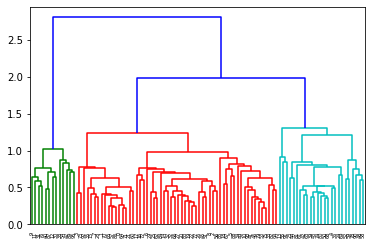

In [119]:
# visualize the tree; classifying down across documents
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

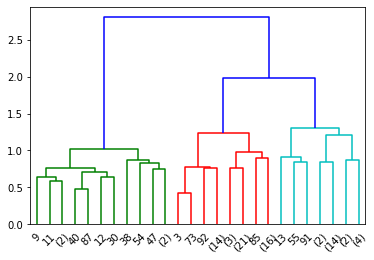

In [224]:
# we can cut the tree after a number of branchings.
# here we 6 primary groupings four layers into the clustering (potentially reflective of our 6 genre types)
# movies generally operate within a bounded space of their genre, with the space offering varying highlighted degrees within sub-topic
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [120]:
# cutting the tree into n branches.
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([2, 2, 2, 2, 4, 2, 2, 2, 2, 1, 2, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 4, 2, 1, 4, 1, 2, 4, 4,
       4, 2, 2, 1, 4, 2, 4, 2, 4, 2, 1, 3, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2,
       2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 1, 2, 4, 2, 4, 4, 2, 2, 2, 2, 2, 1,
       2, 1, 4, 3, 2, 2, 2, 1], dtype=int32)

In [122]:
# look again at metrics -- note the low adjusted rand score
# this reflects the hw code that note quite as good as k-means
# possible we have too many words
# or maybe shouldn't be using TFIDF as that compresses the space
linkage_matrix_full = scipy.cluster.hierarchy.ward(movieCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(movie_df_subset['Type'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(movie_df_subset['Type'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(movie_df_subset['Type'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(movie_df_subset['Type'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.036
Completeness: 0.041
V-measure: 0.039
Adjusted Rand Score: -0.029


In [124]:
movie_df_subset['wald_predictions'] = hierarchicalClusters_full
movie_df_subset.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,Movie Name,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,Type,kmeans_predictions,wald_predictions
0,5992934,Over the Hill,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","['Good', 'morning', 'kitty', 'Come', 'in', 'he...","['good', 'morning', 'kitty', 'come', 'baby', '...",2651,Drama,2,2
1,3904983,A Chump at Oxford,1940,English,"@@3904983 Well , what's the matter now ? - I j...","['Well', 'what', ""'s"", 'the', 'matter', 'now',...","['matter', 'see', 'hand', 'siddown', 'crazy', ...",1056,Comedy,4,2
2,6017201,The Happiest Days of Your Life,1950,English,"@@6017201 BIG BEN CHIMES Excuse me , could you...","['BIG', 'BEN', 'CHIMES', 'Excuse', 'me', 'coul...","['big', 'ben', 'chime', 'excuse', 'tell', 'way...",4247,Comedy,0,4
3,6860500,The Company She Keeps,1951,English,@@6860500 If no-one has any objections . I was...,"['If', 'no', 'one', 'has', 'any', 'objections'...","['objection', 'wonder', 'mildred', 'lynch', 'p...",3067,Drama,2,2
4,4788308,My Son John,1952,English,"@@4788308 What's the matter , pop ? You're get...","['What', ""'s"", 'the', 'matter', 'pop', 'You', ...","['matter', 'pop', 'gettin', 'kinda', 'clumsy',...",4916,Drama,2,2


# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [56]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [57]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [58]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [59]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [60]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [61]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [62]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [63]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(4, 0.3265841), (6, 0.64978725)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [64]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [65]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(4, 0.7297421), (6, 0.24482931)]",0.000000,0.000000,0.000000,0.000000,0.729742,0.000000,0.244829,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(0, 0.43350488), (3, 0.44286853), (4, 0.11968...",0.433505,0.000000,0.000000,0.442869,0.119688,0.000000,0.000000,0.000000,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(1, 0.7390918), (3, 0.026744755), (6, 0.08779...",0.000000,0.739092,0.000000,0.026745,0.000000,0.000000,0.087791,0.000000,0.000000,0.144790
301,06Jun2007Kennedy1.txt,"[(0, 0.6291405), (3, 0.2223084), (9, 0.13391069)]",0.629140,0.000000,0.000000,0.222308,0.000000,0.000000,0.000000,0.000000,0.000000,0.133911
401,08Feb2005Kennedy0.txt,"[(1, 0.034998223), (8, 0.95897067)]",0.000000,0.034998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.958971,0.000000
501,09Nov2005Kennedy11.txt,"[(9, 0.95572317)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955723
601,11Nov2005Kennedy6.txt,"[(5, 0.6834295), (9, 0.2918507)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.683429,0.000000,0.000000,0.000000,0.291851
701,13Jun2006Kennedy1.txt,"[(3, 0.65415776), (5, 0.06304941), (6, 0.25028...",0.000000,0.000000,0.000000,0.654158,0.000000,0.063049,0.250288,0.030502,0.000000,0.000000
801,15Dec2005Kennedy5.txt,"[(0, 0.062169004), (2, 0.07835756), (4, 0.8565...",0.062169,0.000000,0.078358,0.000000,0.856529,0.000000,0.000000,0.000000,0.000000,0.000000
901,16May2007Kennedy5.txt,"[(6, 0.95351434)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.953514,0.000000,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [66]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.000000,0.000000,0.332377,0.00000,0.643994,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.729742,0.00000,0.244829,0.000000,0.0,0.000000
2,0.000000,0.992964,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000
3,0.114499,0.320909,0.000000,0.000000,0.113995,0.00000,0.000000,0.000000,0.0,0.446662
4,0.000000,0.000000,0.179495,0.015215,0.000000,0.80343,0.000000,0.000000,0.0,0.000000
5,0.000000,0.000000,0.756191,0.000000,0.000000,0.00000,0.000000,0.128517,0.0,0.108579
6,0.708496,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.282197,0.0,0.000000
7,0.000000,0.967077,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000
8,0.708329,0.190390,0.000000,0.000000,0.000000,0.00000,0.089171,0.000000,0.0,0.000000
9,0.000000,0.967089,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000


First we can visualize as a stacked bar chart:

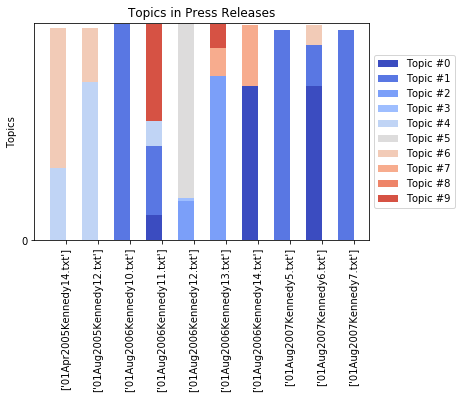

In [67]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

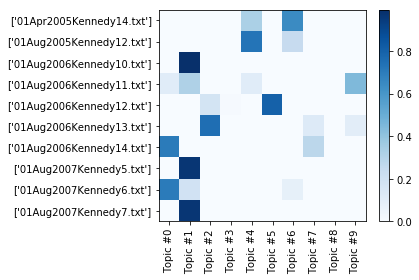

In [68]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [69]:
senlda.show_topic(1)

[('loan', 0.008818487),
 ('fund', 0.007410272),
 ('worker', 0.007204812),
 ('lender', 0.005235563),
 ('company', 0.0040424992),
 ('fda', 0.0033949353),
 ('bankruptcy', 0.0033809415),
 ('unite', 0.0032553007),
 ('follow', 0.0030494125),
 ('head', 0.0030093733)]

And if we want to make a dataFrame:

In [70]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,loan,minimum,worker,fund,worker,fund,worker,loan,head
1,troop,fund,worker,fund,worker,pension,loan,wage,fund,worker
2,worker,worker,wage,teacher,science,fund,lender,fund,aid,fund
3,loan,lender,loan,agency,standard,retirement,unite,minimum,worker,immigrant
4,fail,company,fund,wage,teacher,company,troop,asbestos,wage,immigration
5,judge,fda,immigration,unite,coverage,woman,woman,immigration,unite,wage
6,insurance,bankruptcy,troop,citizen,head,employee,company,woman,lender,company
7,unite,unite,rate,head,loan,unite,concern,follow,minimum,mental
8,hear,follow,hour,resource,leader,loan,ask,victim,company,minimum
9,attorney,head,woman,area,lose,asbestos,insurance,judge,treatment,fda


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

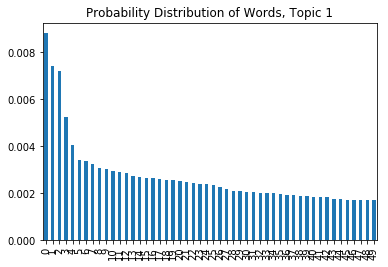

In [71]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [72]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

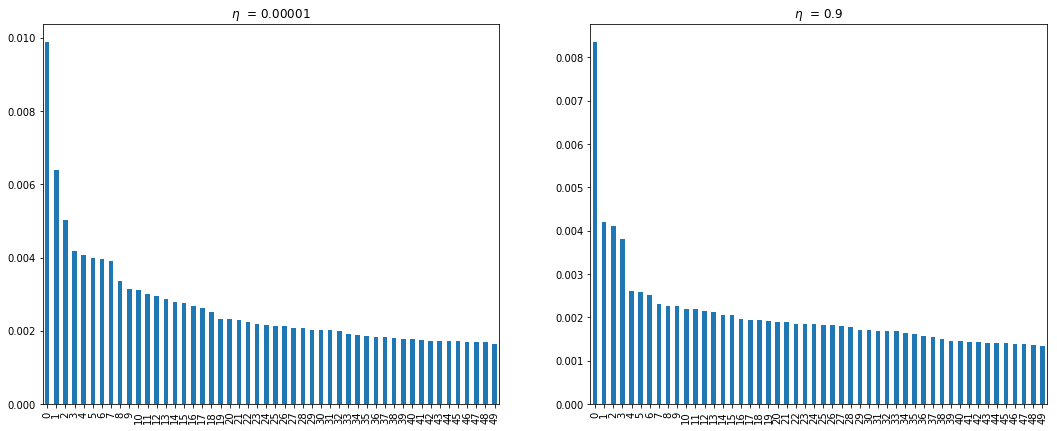

In [73]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [125]:
movie_df_subset.head()

,Unnamed: 0,Movie Name,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,Type,kmeans_predictions,wald_predictions
0,5992934,Over the Hill,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","['Good', 'morning', 'kitty', 'Come', 'in', 'he...","['good', 'morning', 'kitty', 'come', 'baby', '...",2651,Drama,2,2
1,3904983,A Chump at Oxford,1940,English,"@@3904983 Well , what's the matter now ? - I j...","['Well', 'what', ""'s"", 'the', 'matter', 'now',...","['matter', 'see', 'hand', 'siddown', 'crazy', ...",1056,Comedy,4,2
2,6017201,The Happiest Days of Your Life,1950,English,"@@6017201 BIG BEN CHIMES Excuse me , could you...","['BIG', 'BEN', 'CHIMES', 'Excuse', 'me', 'coul...","['big', 'ben', 'chime', 'excuse', 'tell', 'way...",4247,Comedy,0,4
3,6860500,The Company She Keeps,1951,English,@@6860500 If no-one has any objections . I was...,"['If', 'no', 'one', 'has', 'any', 'objections'...","['objection', 'wonder', 'mildred', 'lynch', 'p...",3067,Drama,2,2
4,4788308,My Son John,1952,English,"@@4788308 What's the matter , pop ? You're get...","['What', ""'s"", 'the', 'matter', 'pop', 'You', ...","['matter', 'pop', 'gettin', 'kinda', 'clumsy',...",4916,Drama,2,2


In [126]:
#ensure proper application
movie_df_subset['Tokenized Texts'] = movie_df_subset['Text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
movie_df_subset['normalized_tokens'] = movie_df_subset['Tokenized Texts'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [128]:
movie_df_subset.head()

,Unnamed: 0,Movie Name,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,Type,kmeans_predictions,wald_predictions
0,5992934,Over the Hill,1931,English,"@@5992934 Good morning , kitty ! Come in here ...","[@@5992934, Good, morning, kitty, Come, in, he...","[@@5992934, good, morning, kitty, come, baby, ...",2651,Drama,2,2
1,3904983,A Chump at Oxford,1940,English,"@@3904983 Well , what's the matter now ? - I j...","[@@3904983, Well, what, 's, the, matter, now, ...","[@@3904983, matt, see, hand, siddown, crazy, h...",1056,Comedy,4,2
2,6017201,The Happiest Days of Your Life,1950,English,"@@6017201 BIG BEN CHIMES Excuse me , could you...","[@@6017201, BIG, BEN, CHIMES, Excuse, me, coul...","[@@6017201, big, ben, chime, excuse, tell, way...",4247,Comedy,0,4
3,6860500,The Company She Keeps,1951,English,@@6860500 If no-one has any objections . I was...,"[@@6860500, If, no, one, has, any, objections,...","[@@6860500, objection, wonder, mildred, lynch,...",3067,Drama,2,2
4,4788308,My Son John,1952,English,"@@4788308 What's the matter , pop ? You're get...","[@@4788308, What, 's, the, matter, pop, You, '...","[@@4788308, matt, pop, gettin, kinda, clumsy, ...",4916,Drama,2,2


In [129]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

movie_df_subset['reduced_tokens'] = movie_df_subset['normalized_tokens'].apply(lambda x: dropMissing(x, movieTFVectorizer.vocabulary_.keys()))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [130]:
dictionary = gensim.corpora.Dictionary(movie_df_subset['reduced_tokens'])

In [131]:
# Then for each of the texts we create a list of tuples containing each token and its count.
corpus = [dictionary.doc2bow(text) for text in movie_df_subset['reduced_tokens']]

In [132]:
# Then we serialize the corpus as a file and load it.
gensim.corpora.MmCorpus.serialize('movie.mm', corpus)
moviemm = gensim.corpora.MmCorpus('movie.mm')

In [133]:
# Now we have a correctly formatted corpus that we can use for topic modeling and induction.
movielda = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [137]:
# We can inspect the degree to which distinct texts load on different topics. Here is 'Over the Hill':
# here, topic 0 primarily loads, followed by topic 4
movie1Bow = dictionary.doc2bow(movie_df_subset['reduced_tokens'][0])
movie1lda = movielda[movie1Bow]
print("The topics of the text: {}".format(movie_df_subset['Movie Name'][0]))
print("are: {}".format(movie1lda))

The topics of the text: Over the Hill
are: [(0, 0.6993363), (4, 0.29861295)]


In [139]:
# We can now see which topics our model predicts movie names load on and make this into a dataFrame for later analysis.
ldaDF = pandas.DataFrame({
        'Movie Name' : movie_df_subset['Movie Name'],
        'topics' : [movielda[dictionary.doc2bow(l)] for l in movie_df_subset['reduced_tokens']]
    })

In [141]:
# make each topic its own column:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(movielda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(movielda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF.head()

,Movie Name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Over the Hill,"[(0, 0.6910722), (4, 0.30687705)]",0.691072,0.0,0.000000,0.000000,0.306877,0.00000,0.000000,0.000000,0.000000,0.0
1,A Chump at Oxford,"[(0, 0.61138856), (6, 0.38161808)]",0.611389,0.0,0.000000,0.000000,0.000000,0.00000,0.381618,0.000000,0.000000,0.0
2,The Happiest Days of Your Life,"[(0, 0.048422184), (2, 0.026438786), (4, 0.077...",0.048422,0.0,0.026439,0.000000,0.077165,0.00000,0.265991,0.000000,0.579089,0.0
3,The Company She Keeps,"[(3, 0.03136072), (5, 0.85384953), (7, 0.11242...",0.000000,0.0,0.000000,0.031361,0.000000,0.85385,0.000000,0.112424,0.000000,0.0
4,My Son John,"[(3, 0.9916969)]",0.000000,0.0,0.000000,0.991697,0.000000,0.00000,0.000000,0.000000,0.000000,0.0


In [143]:
# let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['Movie Name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.691072,0.000000,0.000000,0.000000,0.306877,0.00000,0.000000,0.000000,0.000000,0.0
1,0.611389,0.000000,0.000000,0.000000,0.000000,0.00000,0.381618,0.000000,0.000000,0.0
2,0.048422,0.000000,0.026439,0.000000,0.077165,0.00000,0.265991,0.000000,0.579089,0.0
3,0.000000,0.000000,0.000000,0.031361,0.000000,0.85385,0.000000,0.112424,0.000000,0.0
4,0.000000,0.000000,0.000000,0.991697,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.000000,0.000000,0.997205,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
6,0.000000,0.790145,0.000000,0.000000,0.000000,0.00000,0.000000,0.208144,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.995372,0.0
8,0.000000,0.732202,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.264798,0.0
9,0.000000,0.000000,0.000000,0.928001,0.000000,0.00000,0.000000,0.000000,0.068697,0.0


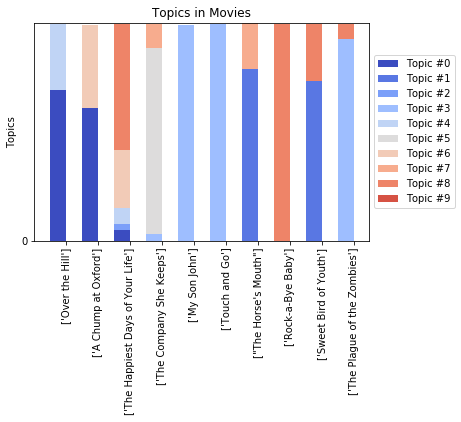

In [145]:
# First we can visualize as a stacked bar chart
# we can see here how different topics load across movie
# note that 'my son john' and 'touch and go' look almost identical whereas most others are more differentiated
# this may point to an interest in more specific analysis
N = 10
ind = np.arange(N)
K = movielda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Movies')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

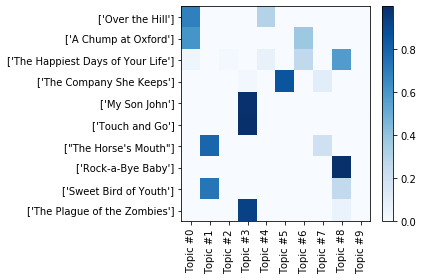

In [146]:
# We can also visualize as a heat map (shows results mirroring the bar charts)
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [147]:
# We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. 
# To look at the terms with the highest LDA weight in topic 1 we can do the following:
# note that topic one loads highly onto 'the horses's mouth' and 'sweet bird of youth'
# further note the use of words that require greater context but also point to contention
## within the documents like 'fuck' and 'bite'
movielda.show_topic(1)

[('fuck', 0.043093935),
 ('jack', 0.01305328),
 ('laugh', 0.00844108),
 ('joe', 0.0075875116),
 ('bite', 0.007123762),
 ('walter', 0.0069028125),
 ('um', 0.005603126),
 ('dude', 0.0055624377),
 ('eye', 0.00550461),
 ('matt', 0.005419687)]

In [148]:
# if we want to make a dataFrame:
topicsDict = {}
for topicNum in range(movielda.num_topics):
    topicWords = [w for w, p in movielda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fuck,fuck,bob,fuck,fuck,fuck,fuck,ron,fuck,fuck
1,johnny,jack,dr,john,um,laugh,ron,laugh,george,jack
2,um,laugh,fuck,matt,laugh,bite,smith,bite,annie,bite
3,ma,joe,daddy,yo,write,shoot,news,fuck,nigga,matt
4,win,bite,marvin,fat,johnny,flow,bite,marry,simon,laugh
5,matt,walter,laugh,suppose,kitty,dr,shoot,news,write,mm
6,fight,um,leo,lie,ma,joy,jack,suppose,um,ron
7,marry,dude,matt,um,bite,write,matt,shoot,papa,master
8,daddy,eye,step,doctor,song,matt,john,matt,rise,um
9,month,matt,mmm,marry,matt,brother,tom,write,marry,fight


In [ ]:
# We can see that several of the topics have the same top words, but there are 
# definitely differences. We can try and make the topics more distinct by 
# changing the α and  𝜂 parameters of the model.
# α controls the sparsity of document-topic loadings
# η (eta) controls the sparsity of topic-word loadings.
## again note the strong presence of 'fuck' and other contentious words like 'bite' and 'fight'

<Figure size 432x288 with 0 Axes>

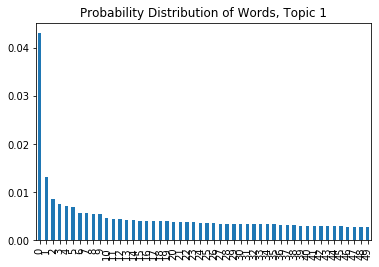

In [150]:
# We can make a visualization of the distribution of words over any single topic.
# largest bar = 'fuck': top word across topics
topic1_df = pandas.DataFrame(movielda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [151]:
# See how different eta values can change the shape of the distribution.
movielda1 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=10, eta = 0.00001)
movielda2 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=10, eta = 0.9)

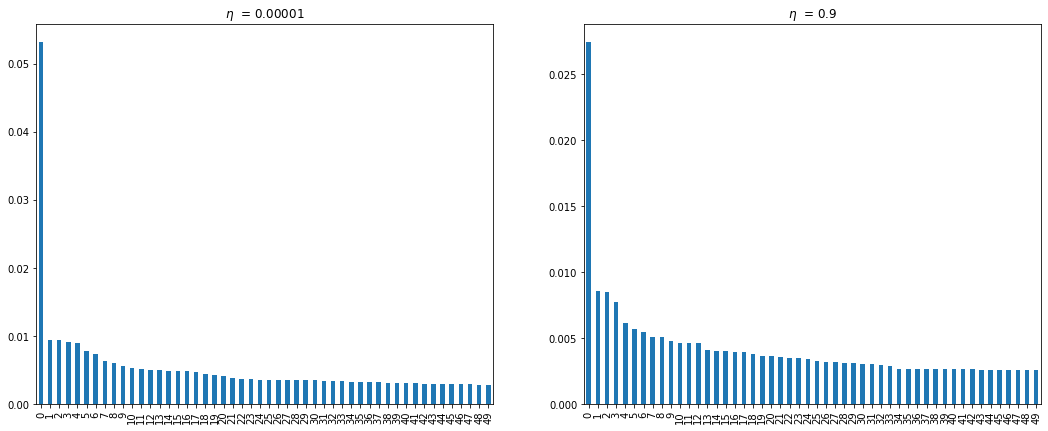

In [152]:
# attempt to make the topics more distinct
# still difficult to differentiate on the basis of these loadings
## note that eta expresses how word-sparse we expect topics to be
# the first bar ('fuck') dominates -- this indicates the significance of this word to this collection
# perhaps removing it would give more insight into the remainder of the corpus
# the significance of a word like 'fuck' indicates a social world with tense moments, potentially countered by words like 'laugh' found above
# this makes sense for action, drama, etc -- movies that often hold intimate family/friend dynamics experiencing strained situations
topic11_df = pandas.DataFrame(movielda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(movielda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

In [257]:
# vary the number of topics
movielda3 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, eta = 0.00001)
movielda4 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, eta = 0.9)

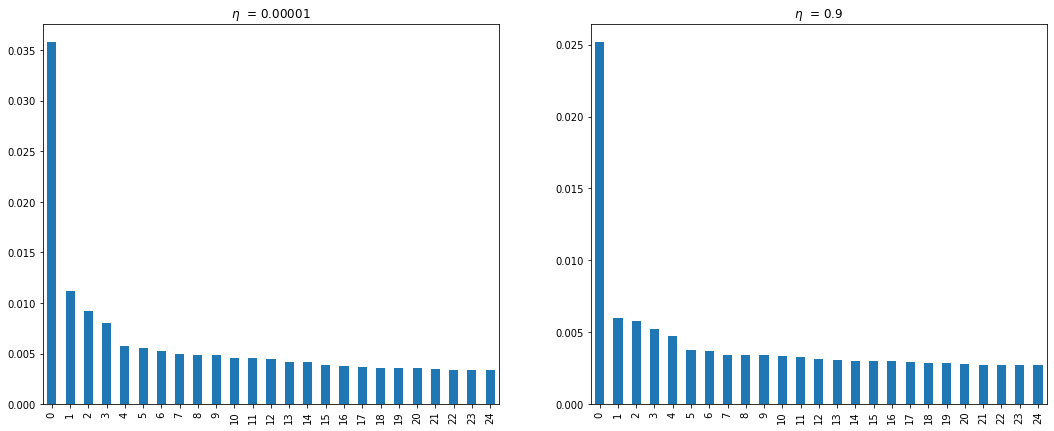

In [258]:
topic3_df = pandas.DataFrame(movielda3.show_topic(1, topn=25))
topic4_df = pandas.DataFrame(movielda4.show_topic(1, topn=25))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic3_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic4_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

In [261]:
# here we vary alpha (controls the sparsity of document-topic loadings)
movielda5 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, alpha=1000, num_topics=10, eta = 0.00001)
movielda6 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, alpha=1000, num_topics=10, eta = 0.9)

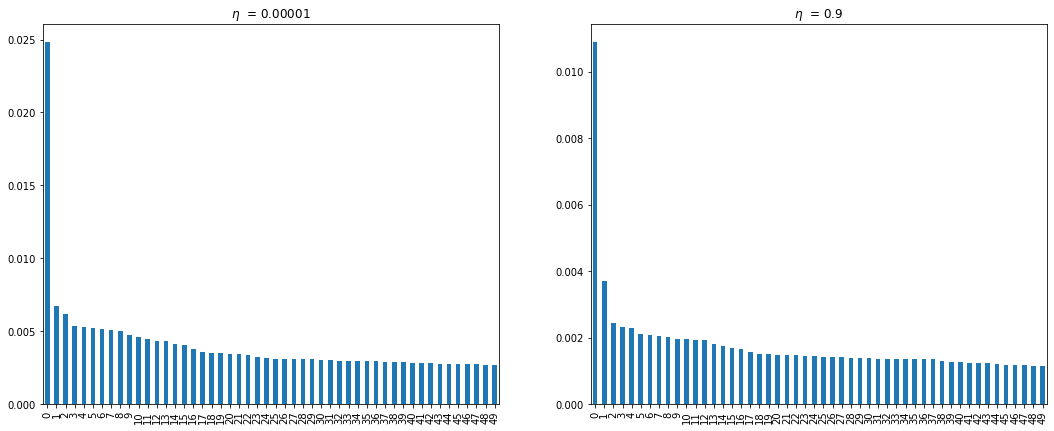

In [262]:
# note that smaller parameter values produce sparser draws
# ("Sparse" in that more values of the topic proportion will be close to zero.)
# what α should capture: your sense of how topically sparse each document is.
# demonstrates a similar result that the movies are similar topically
topic5_df = pandas.DataFrame(movielda5.show_topic(1, topn=50))
topic6_df = pandas.DataFrame(movielda6.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic5_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic6_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [74]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [75]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [76]:
import zipfile
import pandas as pd

In [77]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [78]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [79]:
soap_dict = {}

In [80]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [81]:
soap_dict.keys()

dict_keys(['All My Childen', 'Days of Our Lives', 'Young and Restless', 'One Life to Live', 'Passions', 'As the World Turns', 'Bold and Beautiful', 'Port Charles', 'General Hospital', 'Guiding Light'])

In [82]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [83]:
i = 0

In [84]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
Days of Our Lives
Young and Restless
One Life to Live
Passions
As the World Turns
Bold and Beautiful
Port Charles
General Hospital
Guiding Light


In [85]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Opal, You, unlock, that, door, or, I, 'm, g..."
1,Days of Our Lives,"[@!Brady, Those, two, look, pretty, glum, Wond..."
2,Young and Restless,"[@!John, It, 's, a, statement, under, oath, fr..."
3,One Life to Live,"[@!Melanie, I, ca, n't, believe, Bo, wants, to..."
4,Passions,"[@!Sheridan, I, ruined, everything, by, findin..."
5,As the World Turns,"[@!Rose, Charming, distraction, @(Lucinda, lau..."
6,Bold and Beautiful,"[@!Eric, What, are, you, doing, here, @!Bridge..."
7,Port Charles,"[@!Alison, Ok, so, that, 's, turkey, meatloaf,..."
8,General Hospital,"[@!Lucky, I, 'm, going, to, take, my, hands, o..."
9,Guiding Light,"[@!Reva, I, 'll, only, be, a, minute, @!Ellie,..."


Checking to see which index I should use. In my example it is the first one, so I choose my index as 0. It might be different for you!

In [101]:
dool = soap_df['Tokenized Texts'][1]

In [102]:
' '.join(dool[0:1500])

"@!Brady Those two look pretty glum Wonder what gives @!Belle and Shawn D This must be yours @!Shawn D Yeah I must have mixed them up @!Belle Those are really good but sometimes they put too much mocha in it and you ca n't taste the coffee I hate that @!Shawn D Yeah I 'm always putting so much sugar in I ca n't tell the difference Thinking this is like a bad coffee commercial I stink at small talk @!Belle Thinking I sound like a geek What 's wrong with me Shawn 's a good friend Just talk to him @!Belle and Shawn D Did you @!Belle I 'm sorry Go ahead @!Shawn D No no that 's okay What were you going to say @!Belle Did you get a haircut @!Shawn D No no not recently @!Belle Okay I 'm I 'm going to go @!Shawn D Okay All right no no No wait Let me at least walk you home @!Belle Maybe I 'll just finish my coffee whether to go or stay This is so weird @!Shawn D Thinking this is so dumb There 's only one thing left to do @!Jan Hey @!Jason Hey @!Jan It 's my hero Are you okay @!Jason Yeah yeah I

In [103]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [104]:
import networkx as nx

In [105]:
actor_network = nx.Graph()

In [106]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [107]:
i = 0

In [108]:
all_texts = []

In [109]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

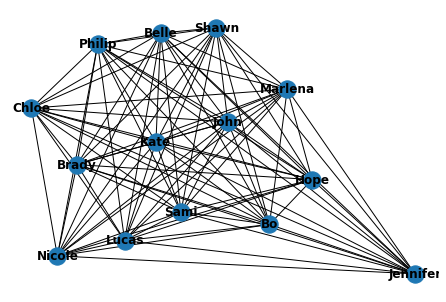

In [110]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [111]:
all_texts[0:10]

[['look', 'pretty', 'glum', 'wonder', 'give'],
 ['shawn', 'have'],
 ['have', 'yes', 'mix'],
 ['good', 'mocha', 'taste', 'coffee', 'hate'],
 ['have',
  'yes',
  'be',
  'putt',
  'sugar',
  'tell',
  'difference',
  'think',
  'like',
  'bad',
  'coffee',
  'commercial',
  'stink',
  'small',
  'talk'],
 ['think',
  'sound',
  'like',
  'geek',
  'wrong',
  'shawn',
  'good',
  'friend',
  'talk'],
 ['shawn', 'have'],
 ['be', 'sorry', 'ahead'],
 ['have', 'okay', 'go'],
 ['haircut']]

In [112]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [113]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [114]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [115]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [116]:
doollda.show_topics()

[(0,
  '0.081*"think" + 0.052*"god" + 0.046*"oh" + 0.033*"let" + 0.031*"well" + 0.029*"maybe" + 0.028*"baby" + 0.027*"fine" + 0.016*"father" + 0.014*"family"'),
 (1,
  '0.058*"uh" + 0.038*"like" + 0.031*"stefano" + 0.026*"tell" + 0.023*"know" + 0.021*"help" + 0.020*"try" + 0.018*"think" + 0.018*"care" + 0.016*"be"'),
 (2,
  '0.213*"yes" + 0.102*"oh" + 0.052*"good" + 0.038*"wait" + 0.034*"tell" + 0.030*"have" + 0.025*"hello" + 0.020*"believe" + 0.020*"right" + 0.017*"wo"'),
 (3,
  '0.033*"get" + 0.032*"stop" + 0.028*"sami" + 0.023*"way" + 0.022*"say" + 0.021*"thing" + 0.021*"like" + 0.019*"kid" + 0.017*"time" + 0.016*"live"'),
 (4,
  '0.091*"come" + 0.076*"hey" + 0.074*"thank" + 0.068*"mean" + 0.021*"leave" + 0.019*"guy" + 0.019*"great" + 0.019*"rafe" + 0.018*"um" + 0.018*"little"'),
 (5,
  '0.054*"sure" + 0.034*"be" + 0.026*"listen" + 0.025*"know" + 0.022*"find" + 0.021*"nicole" + 0.020*"right" + 0.015*"trust" + 0.015*"marry" + 0.015*"wan"'),
 (6,
  '0.151*"okay" + 0.056*"need" + 0.028

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [117]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [118]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.3034643), (2, 0.1954365), (4, 0.17592329), (5, 0.12846257), (6, 0.14431612), (9, 0.052391864)]
[(0, 0.30497184), (2, 0.19622554), (4, 0.17117599), (5, 0.1319705), (6, 0.14008409), (9, 0.055566844)]
[(0, 0.29411888), (2, 0.21385409), (4, 0.1674696), (5, 0.12818722), (6, 0.13829905), (9, 0.058064606)]
[(0, 0.3056512), (2, 0.19965467), (4, 0.16619557), (5, 0.13322118), (6, 0.14049749), (9, 0.05477093)]
[(0, 0.29732493), (2, 0.19455996), (4, 0.16802359), (5, 0.13597804), (6, 0.14156608), (9, 0.06254053)]
[(0, 0.29676658), (2, 0.20434609), (4, 0.17382088), (5, 0.13199311), (6, 0.13556223), (9, 0.05750485)]
[(0, 0.30883044), (2, 0.19253244), (4, 0.17516138), (5, 0.12463086), (6, 0.14231339), (9, 0.05652645)]
[(0, 0.3018075), (2, 0.20189764), (4, 0.17948753), (5, 0.12775597), (6, 0.13357112), (9, 0.05547257)]
[(0, 0.30771273), (2, 0.19967161), (4, 0.17083639), (5, 0.12720011), (6, 0.14107327), (9, 0.053499795)]
[(0, 0.30933246), (2, 0.1958545), (4, 0.17017528), (5, 0.13696381), (6, 0.1

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [119]:
from gensim.matutils import kullback_leibler

In [120]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [121]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

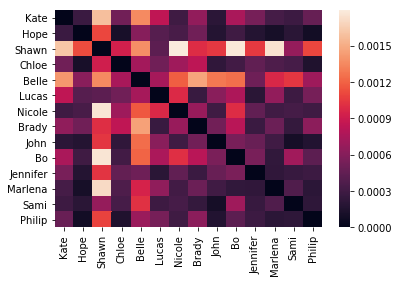

In [122]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [86]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [87]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [88]:
list(coha_texts.keys())[0:5]

['fic_2008_36162.txt',
 'news_1880_780902.txt',
 'mag_1949_182290.txt',
 'news_2005_629411.txt',
 'mag_1924_151906.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [89]:
coha_genres = {}
coha_years = {}

In [90]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [91]:
coha_genres.keys()

dict_keys(['nf', 'fic', 'news', 'mag'])

In [92]:
coha_years.keys()

dict_keys(['1985', '1903', '1864', '1845', '1922', '1957', '1869', '1961', '1982', '2004', '1814', '1995', '1949', '1923', '1856', '1947', '1867', '1857', '1842', '1915', '1945', '2009', '1929', '1926', '1879', '2000', '1948', '1994', '1837', '1918', '1895', '1976', '1861', '2002', '1816', '1970', '1847', '1874', '1939', '1848', '1997', '1811', '1852', '1819', '1877', '1914', '1932', '1911', '1850', '1986', '1944', '1937', '1833', '1822', '1917', '1984', '1840', '1952', '1849', '1843', '1875', '1888', '1868', '1975', '1892', '1851', '1991', '1934', '1897', '1902', '1925', '1955', '1828', '1829', '1871', '1953', '1956', '1873', '1977', '1910', '1826', '1971', '1904', '1967', '1951', '1924', '1920', '1989', '1824', '1954', '1835', '1965', '1844', '1913', '1884', '1988', '1890', '1990', '1933', '1996', '1972', '1865', '1896', '1846', '1838', '1942', '1968', '1941', '1818', '1858', '1827', '1836', '1872', '1943', '1928', '1876', '1960', '1832', '2005', '1962', '1841', '1936', '1919', '1969

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [93]:
import collections

In [94]:
years = []
year_lens = []

In [95]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [96]:
years[0], years[-1]

('1810', '2009')

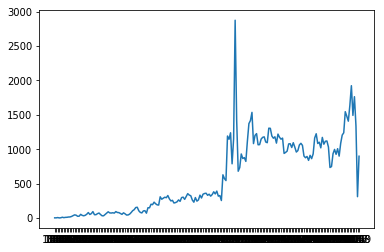

In [97]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: their are far less articles in the beginning, and then it grows. Maybe in our 4 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [126]:
all_texts_coha = []
docs_per_year = [0, 0, 0, 0, 0]
i = 0

In [127]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
            
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size.

In [138]:
def choose_n(corpus, time_slices, nums=1000):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

In [139]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [141]:
dictionary = gensim.corpora.Dictionary(small_corpus)

In [142]:
corpus = [dictionary.doc2bow(text) for text in small_corpus]

In [143]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [144]:
small_docs = [100, 100, 100, 100, 100]

In [134]:
from gensim.models import ldaseqmodel

In [135]:
# ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_year, num_topics=4)

In [147]:
 ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=small_docs, num_topics=4)

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [160]:
ldaseq.print_topics(time=0)[0]

[('man', 0.007132699478346652),
 ('country', 0.004953905335421504),
 ('river', 0.004601016260755985),
 ('come', 0.004500291109021736),
 ('day', 0.0044210075957709935),
 ('time', 0.004133759487293093),
 ('mile', 0.003944137336605276),
 ('find', 0.0039414990087118275),
 ('new', 0.0037711261892743137),
 ('take', 0.0033423523807046478),
 ('place', 0.0033304077024018395),
 ('water', 0.0032852971109775023),
 ('see', 0.0032341722380378798),
 ('horse', 0.003111974959331941),
 ('great', 0.003048816911899102),
 ('captain', 0.002908852096901459),
 ('general', 0.0028690081816825225),
 ('long', 0.002765556386804236),
 ('good', 0.002738278810545999),
 ('leave', 0.0026362890611356504)]

In [161]:
ldaseq.print_topics(time=4)[0]

[('man', 0.008601723705163314),
 ('<', 0.007390083882002291),
 ('come', 0.004732779554721947),
 ('time', 0.004674340167782232),
 ('p', 0.004658272137546079),
 ('day', 0.004440920798263172),
 ('country', 0.004434527009866553),
 ('>', 0.0042715116132568684),
 ('new', 0.00423322281132545),
 ('find', 0.0037647687876274046),
 ('river', 0.0037436664814792854),
 ('go', 0.0035399899048840144),
 ('take', 0.0033760965399826826),
 ('place', 0.0033265438797066144),
 ('see', 0.003210924518629936),
 ('mile', 0.0031607174358631368),
 ('year', 0.003150383583558314),
 ('horse', 0.0029602366528247745),
 ('long', 0.0029182123328693986),
 ('great', 0.0028928820979905005)]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [153]:
# here we look at SOAP, another relevant media corpus that allows into into questions of violence/nonviolence in these movies
corpora_address = "/Users/laurenbeard/Downloads/SOAP"

In [154]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [155]:
import zipfile
import pandas as pd

In [156]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [157]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [158]:
soap_dict = {}

In [159]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [160]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [161]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [162]:
i = 0

In [163]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [195]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


In [196]:
# focus here on 'general hospital', a movie that relates to themes of life/death/saving etc
dool = soap_df['Tokenized Texts'][4]

In [197]:
' '.join(dool[0:1500])

"@!Luke I signed my divorce papers You and I are both free @!Lucy Welcome to the eighth annual nurses ball @!Edward @(Singing It 's there in his kiss @!Bobbie I got to go @!Lucy They all got paged to the emergency room @!Zander Somebody help over here @!Lucy I have a really bad feeling about tonight @!Lucy Well hello everybody I 'm back Oh thank you Thank you very very much Oh and thank you to Victor Victor you did a terrific job filling in for me Let 's give a big hand to Victor We have a true crisis that 's developed downstairs The Manhattan train hit a bus It was stalled on its tracks and everything seems to be under control but all our wonderful doctors and nurses are downstairs working very hard fighting to save everyone 's lives and the injured so um I thought as I was making my way back up here it 'd be a wonderful time to dedicate the ball to them and into our pockets and make sure that this ball tonight is the very best ball ever And now I am going to come down in that audienc

In [198]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [199]:
import networkx as nx

In [200]:
actor_network = nx.Graph()

In [201]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [202]:
i = 0

In [203]:
all_texts = []

In [204]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


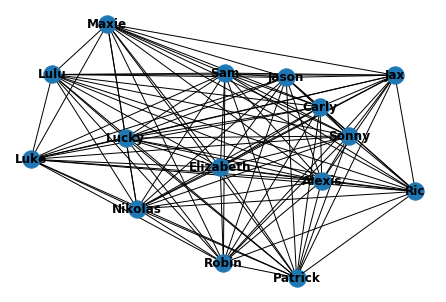

In [205]:
# draw network graph of primary characters across general hospital
# note that the network is fairly connected; there do not appear to be specific sub-groups
# we see a more interrconnected group here, rather than competing sub-groups
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [206]:
# create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character
# note the little emphasis on 'saving' language in a show that is oriented to a hospital setting
all_texts[0:10]

[['sign', 'divorce', 'paper', 'free'],
 ['okay', 'think', 'elizabeth', 'get', 'sick', 'stage', 'fright'],
 ['okay'],
 ['yes'],
 ['okay',
  'right',
  'know',
  'idea',
  'raise',
  'money',
  'aid',
  'research',
  'good',
  'time',
  'right'],
 ['fun'],
 ['hey', 'hey', 'hey', 'face', 'man', 'stick', 'night'],
 ['uh', 'relax', 'right', 'way', 'helena', 'try', 'crowd'],
 ['right', 'let'],
 ['okay', 'count', 'be', 'ahead']]

In [207]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [208]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [209]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [210]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [211]:
doollda.show_topics()

[(0,
  '0.072*"go" + 0.046*"tell" + 0.045*"be" + 0.022*"need" + 0.019*"father" + 0.019*"um" + 0.017*"dad" + 0.015*"sonny" + 0.015*"ask" + 0.013*"course"'),
 (1,
  '0.161*"know" + 0.062*"think" + 0.029*"want" + 0.026*"maybe" + 0.024*"sigh" + 0.020*"find" + 0.019*"thing" + 0.018*"mean" + 0.016*"believe" + 0.013*"need"'),
 (2,
  '0.078*"want" + 0.032*"have" + 0.031*"get" + 0.026*"know" + 0.024*"carly" + 0.022*"time" + 0.021*"care" + 0.019*"little" + 0.019*"think" + 0.016*"stop"'),
 (3,
  '0.085*"na" + 0.085*"gon" + 0.083*"right" + 0.038*"baby" + 0.035*"uh" + 0.029*"look" + 0.026*"johnny" + 0.015*"listen" + 0.015*"cause" + 0.013*"know"'),
 (4,
  '0.162*"be" + 0.040*"sorry" + 0.029*"say" + 0.029*"leave" + 0.024*"fine" + 0.018*"go" + 0.017*"great" + 0.017*"think" + 0.014*"long" + 0.014*"night"'),
 (5,
  '0.098*"oh" + 0.058*"thank" + 0.047*"sure" + 0.043*"good" + 0.032*"kate" + 0.031*"kid" + 0.025*"god" + 0.020*"chuckle" + 0.016*"lulu" + 0.015*"hmm"'),
 (6,
  '0.226*"okay" + 0.101*"come" + 0.

In [212]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

In [213]:
# We now have topic distributions for each character. Let us have a brief look at what the characters are talking about.
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.047058873), (1, 0.48944455), (3, 0.22649042), (4, 0.116655275), (5, 0.12034245)]
[(0, 0.05142646), (1, 0.49070582), (3, 0.21854265), (4, 0.12116707), (5, 0.11815024)]
[(0, 0.05247132), (1, 0.48807082), (3, 0.22109595), (4, 0.11683767), (5, 0.12151558)]
[(0, 0.051848326), (1, 0.47862175), (3, 0.2313087), (4, 0.119758315), (5, 0.11845441)]
[(0, 0.052911784), (1, 0.47306153), (3, 0.23294541), (4, 0.123724565), (5, 0.11735292)]
[(0, 0.059626285), (1, 0.47964418), (3, 0.22318527), (4, 0.12349815), (5, 0.11404192)]
[(0, 0.043209188), (1, 0.48862508), (3, 0.23333241), (4, 0.113461226), (5, 0.12136469)]
[(0, 0.052650087), (1, 0.48202246), (3, 0.22475046), (4, 0.12141396), (5, 0.11915523)]
[(0, 0.045966256), (1, 0.4883182), (3, 0.2255578), (4, 0.11499381), (5, 0.12515427)]
[(0, 0.05427355), (1, 0.4791363), (3, 0.2310675), (4, 0.11619276), (5, 0.11932443)]
[(0, 0.047200445), (1, 0.4803682), (3, 0.23004775), (4, 0.12147789), (5, 0.120895624)]
[(0, 0.053681456), (1, 0.47852382), (3, 0.23143

In [214]:
from gensim.matutils import kullback_leibler

In [215]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [216]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

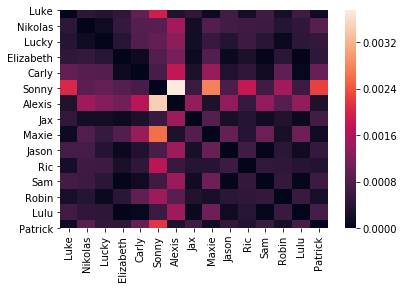

In [217]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
# we see generally little overlap and that certain actors have more influence than others
# the representation of a show as related to a hospital setting but not generally collaborative
# and actually more contentious gives interesting insights into a (lack of) emphasis
# on care, life-saving, and collaboration -- as was similar in the overwhelming use of
# violence-oriented languge in the movies discussed above